In [126]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.io.wavfile import read as read_wav
from scipy import fft,signal
from sklearn.preprocessing import minmax_scale
import warnings
from tqdm import tqdm

TONE_A = 440 
NOTES = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#'] 

# feature extraction on intervals of the first two chords
# find the top 10 most frequent intervals
# use the top 10 most frequent intervals as features

def freq_to_rnote(freq):
    r = 12.0*np.log2(freq/TONE_A)
    return r

def rnote_to_freq(r):
    f = TONE_A*2**(r/12)
    return f

def get_note_volume(rnote,fft_image,fft_freq,rnote_epsilon=0.2):
    """ rnote - name or number of note,fft_image - fourier image of signal,
    fft_freq - frequencies in fft_image,rnote_epsilon - halfwide of window to inspect
    return maximum volume(magnitude) of signal in freq window for rnote """
    if isinstance(rnote,str):
        rnote = NOTES.index(rnote)
    try:
        f0 = rnote_to_freq(rnote-rnote_epsilon)
        f1 = rnote_to_freq(rnote+rnote_epsilon)
        f_idx = np.where((fft_freq>=f0)&(fft_freq<=f1)) 
        maxVol = np.max((fft_image[f_idx]))
    except Exception:
        return 0.
    
    return maxVol

def get_notes_volume(rnote,fft_image,fft_freq,rnote_epsilon=0.5,oct_range_from=-4.,oct_range_to=8.):
    if isinstance(rnote,str):
        rnote = NOTES.index(rnote)
    rnotes = np.arange(rnote+12.*oct_range_from,rnote+12.*oct_range_to,12.0)
    vol = []
    for rn in rnotes:
        vol.append(get_note_volume(rn,fft_image,fft_freq))
        
    return np.max(vol)

def chord_quality(fileName):
    rate, data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32) # stereo of any type -> mono of float32
    data = minmax_scale(data,(-1.,1.))
    fft_image = np.abs(fft.rfft(data,norm='forward'))
    fft_freq = fft.rfftfreq(len(data),1./rate)

    major_vol = []
    minor_vol = []
    diminished_vol = []
    augmented_vol = []

    for rnote in range(12):
        vol = get_notes_volume(rnote,fft_image,fft_freq)
        v3 = get_notes_volume((rnote+3)%12,fft_image,fft_freq)
        v4 = get_notes_volume((rnote+4)%12,fft_image,fft_freq)
        v6 = get_notes_volume((rnote+6)%12,fft_image,fft_freq)
        v7 = get_notes_volume((rnote+7)%12,fft_image,fft_freq)
        v8 = get_notes_volume((rnote+8)%12,fft_image,fft_freq)

        major_vol.append(vol + v4 + v7)
        minor_vol.append(vol + v3 + v7)
        diminished_vol.append(vol + v3 + v6)
        augmented_vol.append(vol + v4 + v8)
    
    major_max = [max(major_vol), NOTES[major_vol.index(max(major_vol))]]
    minor_max = [max(minor_vol), NOTES[minor_vol.index(max(minor_vol))]] 
    diminished_max = [max(diminished_vol), NOTES[diminished_vol.index(max(diminished_vol))]] 
    augmented_max = [max(augmented_vol), NOTES[augmented_vol.index(max(augmented_vol))]] 

    if max(major_max[0], minor_max[0], diminished_max[0], augmented_max[0]) == major_max[0]:
        return 'maj', major_max[1]
    elif max(major_max[0], minor_max[0], diminished_max[0], augmented_max[0]) == minor_max[0]:
        return 'min', minor_max[1]
    elif max(major_max[0], minor_max[0], diminished_max[0], augmented_max[0]) == diminished_max[0]:
        return 'dim', diminished_max[1]
    else:
        return 'aug', augmented_max[1]

In [137]:
# given the chord quality, intervals and note volumes, create a model that predicts the root note using 
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# try it out on a few of the files in /data/train_set.csv:
train_set = pd.read_csv('data/train_set.csv')
test_set = pd.read_csv('data/test_set.csv')
print(train_set.head())

# remove the chords that are not maj or min in the Quality column
train_set = train_set[train_set['Quality'].isin(['maj', 'min', 'dim'])]
test_set = test_set[test_set['Quality'].isin(['maj', 'min', 'dim'])]

train_set['File Path'] = train_set['File Path'].str.replace('#', 's')
test_set['File Path'] = test_set['File Path'].str.replace('#', 's')

                                    File Path Root Note  Octave Quality  \
0        data/chords/dim/Eb-7-dim-chord-1.wav        Eb       7     dim   
1   data/chords/min7b5/C-3-min7b5-chord-1.wav         C       3  min7b5   
2       data/chords/dim7/E-6-dim7-chord-0.wav         E       6    dim7   
3        data/chords/min/Bb-5-min-chord-0.wav        Bb       5     min   
4  data/chords/maj7_2/Ab-5-maj7_2-chord-0.wav        Ab       5  maj7_2   

   Inversion  
0          1  
1          1  
2          0  
3          0  
4          0  


In [178]:
def preprocess(fileName):
    rate, data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32) # stereo of any type -> mono of float32
    data = minmax_scale(data,(-1.,1.))
    fft_image = np.abs(fft.rfft(data,norm='forward'))
    fft_freq = fft.rfftfreq(len(data),1./rate)

    major_vol = []
    minor_vol = []
    diminished_vol = []
    augmented_vol = []

    note_vols = np.zeros(12)

    for rnote in range(12):
        note_vols[rnote] = get_notes_volume(rnote,fft_image,fft_freq)
    
    # get the indexes of the top 3 notes
    top_notes = note_vols.argsort()[-3:][::-1]
    
    # get the differences between the top 3 notes
    diffs = []
    for i in range(len(top_notes)-1):
        diffs.append(top_notes[i] - top_notes[i+1])
    
    diffs.append(top_notes[0] - top_notes[-1])

    return diffs, note_vols
 

In [139]:
# add the diffs and note_vols columns to the train set, where each diff note_vol is a different column
for j in range(3):
    train_set['diff' + str(j)] = None

for k in range(12):
    train_set['note_vol' + str(k)] = None

diffs = []
note_vols = []
for i in tqdm(range(len(train_set))):
    diff, note_vol = preprocess(train_set['File Path'].iloc[i])
    diffs.append(diff)
    note_vols.append(note_vol)

    try:
        # set the columns diff_0 to diff_2 and note_0 to note_11 at train_set index i to the values in diff and note_vol
        for j in range(3):
            train_set['diff' + str(j)].iloc[i] = diff[j]
        
        for k in range(12):
            train_set['note_vol' + str(k)].iloc[i] = note_vol[k]
    except:
        print(diff, note_vol)

for j in range(3):
    test_set['diff' + str(j)] = None

for k in range(12):
    test_set['note_vol' + str(k)] = None


for i in tqdm(range(len(test_set))):
    diff, note_vol = preprocess(test_set['File Path'].iloc[i])
    diffs.append(diff)
    note_vols.append(note_vol)

    try:
        # set the columns diff_0 to diff_2 and note_0 to note_11 at train_set index i to the values in diff and note_vol
        for j in range(3):
            test_set['diff' + str(j)].iloc[i] = diff[j]
        
        for k in range(12):
            test_set['note_vol' + str(k)].iloc[i] = note_vol[k]
    except:
        print(diff, note_vol)


  0%|          | 0/534 [00:00<?, ?it/s]/var/folders/x_/0gc9r1qx05nfx7tp3rdjsf340000gn/T/ipykernel_2899/905799374.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['diff' + str(j)].iloc[i] = diff[j]
/var/folders/x_/0gc9r1qx05nfx7tp3rdjsf340000gn/T/ipykernel_2899/905799374.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['diff' + str(j)].iloc[i] = diff[j]
/var/folders/x_/0gc9r1qx05nfx7tp3rdjsf340000gn/T/ipykernel_2899/905799374.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [130]:
# scale the note_vols columns
for k in range(12):
    train_set['note_vol' + str(k)] = minmax_scale(train_set['note_vol' + str(k)])
    test_set['note_vol' + str(k)] = minmax_scale(test_set['note_vol' + str(k)])

In [155]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

534 231 534 231


In [146]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Convert chord quality to numeric using Label Encoding
le = LabelEncoder()
train_set['ChordQuality'] = le.fit_transform(train_set['Quality'])
test_set['ChordQuality'] = le.fit_transform(test_set['Quality'])


# Define features (X) and target variable (y)
X = train_set.drop(columns=['Root Note', 'File Path', 'Inversion', 'Octave'])
y = train_set['Root Note']
X['Quality'] = le.fit_transform(X['Quality'])


X_test = test_set.drop(columns=['Root Note', 'File Path', 'Inversion', 'Octave'])
y_test = test_set['Root Note']
X_test['Quality'] = le.fit_transform(X_test['Quality'])

# Create a Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Train the model
decision_tree_model.fit(X, y)

# Make predictions on the test set
y_pred = decision_tree_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Now, you can use the trained model to predict the root note for new data
# new_data = pd.DataFrame(...)  # Prepare new data
# predicted_root_note = model.predict(new_data)

Accuracy: 0.8268398268398268


In [104]:
# do the same thing with KNN
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN model
model = KNeighborsClassifier(n_neighbors=2)

# Train the model
model.fit(X, y)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.5021645021645021


In [105]:
# try the same thing with SVM
from sklearn.svm import SVC

# Create a SVM model
model = SVC()

# Train the model
model.fit(X, y)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.20346320346320346


In [147]:
# try the same thing with Random Forest
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X, y)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.922077922077922


In [53]:
print(X.iloc[0])
print(y.describe())
print(y_test.describe())

Quality                1
diff0                  9
diff1                 -1
diff2                  8
note_vol0       0.000515
note_vol1       0.000498
note_vol2       0.000083
note_vol3       0.000102
note_vol4       0.000124
note_vol5       0.000108
note_vol6       0.000386
note_vol7        0.00019
note_vol8       0.000105
note_vol9       0.000659
note_vol10       0.00031
note_vol11      0.000109
ChordQuality           1
Name: 0, dtype: object
count     713
unique     12
top         C
freq       81
Name: Root Note, dtype: object
count     307
unique     12
top         G
freq       38
Name: Root Note, dtype: object


In [149]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Assuming you have X and y loaded from your dataset

# Convert 'Root Note' values to their corresponding indices
NOTES = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']
y = y.replace('Eb', 'D#')
y = y.replace('Bb', 'A#')
y = y.replace('Ab', 'G#')
y_test = y_test.replace('Eb', 'D#')
y_test = y_test.replace('Bb', 'A#')
y_test = y_test.replace('Ab', 'G#')
y_encoded = np.array([NOTES.index(note) for note in y])
y_test_encoded = np.array([NOTES.index(note) for note in y_test])


# Ensure that data types are compatible with TensorFlow
X_train = X.astype(np.float32)  # Adjust the data type accordingly
y_train = y_encoded.astype(np.int32)    # Adjust the data type accordingly
X_test = X_test.astype(np.float32)    # Adjust the data type accordingly
y_test = y_test_encoded.astype(np.int32)      # Adjust the data type accordingly


In [119]:
print(X_train.iloc[0])
print(y_test[0])

Quality         0.000000
diff0           9.000000
diff1          -1.000000
diff2           8.000000
note_vol0       0.016903
note_vol1       0.013491
note_vol2       0.000681
note_vol3       0.001427
note_vol4       0.002233
note_vol5       0.001773
note_vol6       0.007451
note_vol7       0.003018
note_vol8       0.001532
note_vol9       0.013553
note_vol10      0.006719
note_vol11      0.001285
ChordQuality    0.000000
Name: 0, dtype: float32
8


In [142]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Epoch 1/100
5/5 [==============================] - 0s 24ms/step - loss: 3.6843 - accuracy: 0.1007 - val_loss: 2.4785 - val_accuracy: 0.1028
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 3.2621 - accuracy: 0.1475 - val_loss: 2.4501 - val_accuracy: 0.1402
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 2.9945 - accuracy: 0.1358 - val_loss: 2.4216 - val_accuracy: 0.2150
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 3.0447 - accuracy: 0.1522 - val_loss: 2.3905 - val_accuracy: 0.2617
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 2.9055 - accuracy: 0.1756 - val_loss: 2.3613 - val_accuracy: 0.2617
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 2.8664 - accuracy: 0.1616 - val_loss: 2.3328 - val_accuracy: 0.2897
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 2.7788 - accuracy: 0.1897 - val_loss: 2.3060 - val_accuracy: 0.2804
Epoch 8/100
5/5 [=========

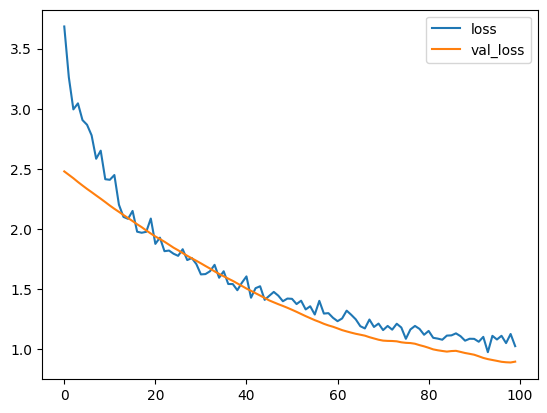

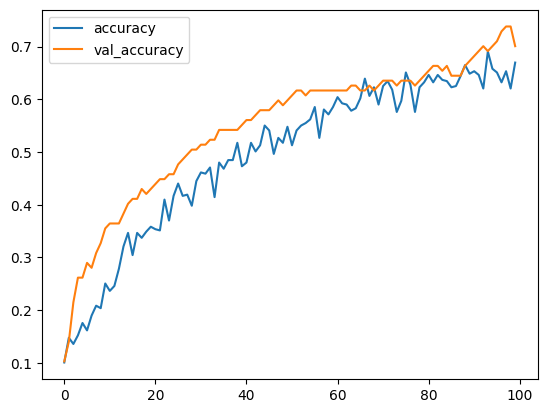

In [150]:
from tensorflow.keras.layers import BatchNormalization


ffnn_model = Sequential([
    Dense(256, activation='relu', input_shape=(17,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(12, activation='sigmoid')
])


ffnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = ffnn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    batch_size=100,
    epochs=100,
    verbose=1
)

# Evaluate the model on the test set
results = ffnn_model.evaluate(X_test_scaled, y_test)

# Plot the accuracy and loss curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

# Make predictions with the model
y_pred = ffnn_model.predict(X_test_scaled)

# Get the predicted class with the highest probability for each sample
y_pred_encoded = np.argmax(y_pred, axis=1)
# y_pred_notes = [NOTES[index] for index in y_pred_encoded]

# Get the classification report
report = classification_report(y_test_encoded, y_pred_encoded)
print(report)


In [145]:
test_loss, test_accuracy = ffnn_model.evaluate(X_test_scaled, y_test, verbose=2)
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

8/8 - 0s - loss: 0.8486 - accuracy: 0.7489 - 19ms/epoch - 2ms/step
Test loss: 0.85. Test accuracy: 74.89%


In [172]:
# set up an ensemble method: use 50% from the decision tree, 50% from the neural network
# get the predictions from the decision tree
y_pred_dt = decision_tree_model.predict(X_test)
y_pred_dt_modified = np.copy(y_pred_dt)
y_pred_dt_modified[y_pred_dt_modified == 'Eb'] = 'D#'
y_pred_dt_modified[y_pred_dt_modified == 'Bb'] = 'A#'
y_pred_dt_modified[y_pred_dt_modified == 'Ab'] = 'G#'
y_pred_dt_encoded = [NOTES.index(note) if note in NOTES else -1 for note in y_pred_dt_modified]

# get the predictions from the neural network
y_pred_nn = ffnn_model.predict(X_test_scaled)
y_pred_nn_encoded = np.argmax(y_pred_nn, axis=1)

# get the predictions from the random forest
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_modified = np.copy(y_pred_dt)
y_pred_rf_modified[y_pred_rf_modified == 'Eb'] = 'D#'
y_pred_rf_modified[y_pred_rf_modified == 'Bb'] = 'A#'
y_pred_rf_modified[y_pred_rf_modified == 'Ab'] = 'G#'
y_pred_rf_encoded = [NOTES.index(note) if note in NOTES else -1 for note in y_pred_rf_modified]

# combine the predictions
y_pred_combined = []
for i in range(len(y_pred_dt_encoded)):
    y_pred_combined.append([y_pred_dt_encoded[i], y_pred_nn_encoded[i], y_pred_rf_encoded[i]])

# get the most common prediction
y_pred_combined_encoded = []
for i in range(len(y_pred_combined)):
    y_pred_combined_encoded.append(np.bincount(y_pred_combined[i]).argmax())

# get the classification report
report = classification_report(y_test_encoded, y_pred_combined_encoded)
print(report)

8/8 [==============================] - 0s 740us/step
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        16
           1       0.89      0.73      0.80        22
           2       0.73      0.80      0.76        10
           3       0.59      0.83      0.69        12
           4       0.94      0.80      0.86        20
           5       0.76      0.90      0.83        21
           6       0.84      0.80      0.82        20
           7       0.84      0.94      0.89        17
           8       0.95      0.64      0.77        28
           9       0.63      0.75      0.69        16
          10       0.90      0.90      0.90        29
          11       1.00      0.95      0.97        20

    accuracy                           0.83       231
   macro avg       0.82      0.83      0.82       231
weighted avg       0.84      0.83      0.83       231



In [174]:
# get the accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_combined_encoded)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8268398268398268


### Different Approach: Using The given chord to extract information that points to the Root Note


Idea: take the given quality, and go through a list of chords of that type to find the root note that has the highest volume score for that quality

In [234]:
# based on the note volumes, create 4 new features that are the top 4 note indices in the note volume columns
def preprocess_rnote_extract(fileName, quality):
    rate, data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32) # stereo of any type -> mono of float32
    data = minmax_scale(data,(-1.,1.))
    fft_image = np.abs(fft.rfft(data,norm='forward'))
    fft_freq = fft.rfftfreq(len(data),1./rate)

    note_vols = np.zeros(12)

    rnote_weights = np.zeros(12)

    for rnote in range(12):
        note_vols[rnote] = get_notes_volume(rnote,fft_image,fft_freq)

        vol = get_notes_volume(rnote,fft_image,fft_freq)
        v3 = get_notes_volume((rnote+3)%12,fft_image,fft_freq)
        v4 = get_notes_volume((rnote+4)%12,fft_image,fft_freq)
        v6 = get_notes_volume((rnote+6)%12,fft_image,fft_freq)
        v7 = get_notes_volume((rnote+7)%12,fft_image,fft_freq)
        v8 = get_notes_volume((rnote+8)%12,fft_image,fft_freq)

        if quality == "min":
            rnote_weights[rnote] = vol + v3 + v7
        elif quality == "maj":
            rnote_weights[rnote] = vol + v4 + v7
        elif quality == "dim":
            rnote_weights[rnote] = vol + v3 + v6
        else:
            rnote_weights[rnote] = vol + v4 + v8
        
    # get the index of the top 4 notes, in order
    top_r_notes = rnote_weights.argsort()[-4:][::-1]

    # get the indexes of the top 3 notes
    top_notes = note_vols.argsort()[-3:][::-1]
    
    # get the differences between the top 3 notes
    diffs = []
    for i in range(len(top_notes)-1):
        diffs.append(top_notes[i] - top_notes[i+1])
    
    diffs.append(top_notes[0] - top_notes[-1])

    return diffs, note_vols, top_r_notes

In [235]:
# given the chord quality, intervals and note volumes, create a model that predicts the root note using 
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# try it out on a few of the files in /data/train_set.csv:
train_set = pd.read_csv('data/train_set.csv')
test_set = pd.read_csv('data/test_set.csv')
print(train_set.head())

# remove the chords that are not maj or min in the Quality column
train_set = train_set[train_set['Quality'].isin(['maj', 'min', 'dim'])]
test_set = test_set[test_set['Quality'].isin(['maj', 'min', 'dim'])]

train_set['File Path'] = train_set['File Path'].str.replace('#', 's')
test_set['File Path'] = test_set['File Path'].str.replace('#', 's')

                                    File Path Root Note  Octave Quality  \
0        data/chords/dim/Eb-7-dim-chord-1.wav        Eb       7     dim   
1   data/chords/min7b5/C-3-min7b5-chord-1.wav         C       3  min7b5   
2       data/chords/dim7/E-6-dim7-chord-0.wav         E       6    dim7   
3        data/chords/min/Bb-5-min-chord-0.wav        Bb       5     min   
4  data/chords/maj7_2/Ab-5-maj7_2-chord-0.wav        Ab       5  maj7_2   

   Inversion  
0          1  
1          1  
2          0  
3          0  
4          0  


In [232]:
len(train_set)

985

In [236]:
preprocess_rnote_extract(train_set['File Path'].iloc[0], train_set['Quality'].iloc[0])

([9, -1, 8],
 array([5.14683663e-04, 4.98163980e-04, 8.30797944e-05, 1.02320169e-04,
        1.23592006e-04, 1.07863976e-04, 3.86379659e-04, 1.89827930e-04,
        1.05026404e-04, 6.59153040e-04, 3.10034287e-04, 1.09101835e-04]),
 array([6, 9, 3, 0]))

In [231]:
for i in tqdm(range(len(train_set))):
    diff, note_vol, top_notes = preprocess_rnote_extract(train_set['File Path'].iloc[i], train_set['Quality'].iloc[i])

    # Add columns and assign values in the same loop
    for j in range(3):
        train_set[i, 'diff' + str(j)] = diff[j]
    
    for k in range(12):
        train_set.at[i, 'note_vol' + str(k)] = note_vol[k]

    for l in range(4):
        train_set.at[i, 'top_note' + str(l)] = top_notes[l]



 37%|███▋      | 287/784 [00:04<00:08, 61.93it/s]/var/folders/x_/0gc9r1qx05nfx7tp3rdjsf340000gn/T/ipykernel_2899/2744603887.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set[i, 'diff' + str(j)] = diff[j]
/var/folders/x_/0gc9r1qx05nfx7tp3rdjsf340000gn/T/ipykernel_2899/2744603887.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set[i, 'diff' + str(j)] = diff[j]
/var/folders/x_/0gc9r1qx05nfx7tp3rdjsf340000gn/T/ipykernel_2899/2744603887.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

TypeError: integer argument expected, got float

In [191]:
# add the diffs and note_vols columns to the train set, where each diff note_vol is a different column
for j in range(3):
    train_set['diff' + str(j)] = None

for k in range(12):
    train_set['note_vol' + str(k)] = None

for l in range(4):
    train_set['top_note' + str(l)] = None

diffs = []
note_vols = []
note_weights = []
top_rnotes = []

for i in tqdm(range(len(train_set))):
    diff, note_vol = preprocess_rnote_extract(train_set['File Path'].iloc[i])

rate, data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32) # stereo of any type -> mono of float32
    data = minmax_scale(data,(-1.,1.))
    fft_image = np.abs(fft.rfft(data,norm='forward'))
    fft_freq = fft.rfftfreq(len(data),1./rate)
    
    diffs.append(diff)
    note_vols.append(note_vol)

    for note in NOTES:
        note_weight = get_notes_volume(note,fft_image,fft_freq)
        note_weights.append(note_weight)

    try:
        # set the columns diff_0 to diff_2 and note_0 to note_11 at train_set index i to the values in diff and note_vol
        for j in range(3):
            train_set['diff' + str(j)].iloc[i] = diff[j]
        
        for k in range(12):
            train_set['note_vol' + str(k)].iloc[i] = note_vol[k]
        
        for l in range(4):
            train_set['top_note' + str(l)].iloc[i] = top_notes[l]
        
    except:
        print(diff, note_vol)

        

100%|██████████| 231/231 [00:03<00:00, 60.39it/s]


In [196]:
print(train_set.head())
# find how many Nan values there are in each column
print(train_set.isnull().sum())

len(train_set)

len(test_set)

                               File Path Root Note  Octave Quality  Inversion  \
0   data/chords/dim/Eb-7-dim-chord-1.wav        Eb     7.0     dim        1.0   
3   data/chords/min/Bb-5-min-chord-0.wav        Bb     5.0     min        0.0   
20  data/chords/maj/Ab-3-maj-chord-1.wav        Ab     3.0     maj        1.0   
36   data/chords/min/E-1-min-chord-1.wav         E     1.0     min        1.0   
43  data/chords/maj/Bb-3-maj-chord-2.wav        Bb     3.0     maj        2.0   

   diff0 diff1 diff2 note_vol0 note_vol1  ... note_vol7 note_vol8 note_vol9  \
0     -3     6     3  0.000515  0.000498  ...   0.00019  0.000105  0.000659   
3      3     4    -2  0.004596   0.00303  ...  0.041377   0.00304   0.00498   
20     7    -3     1   0.01658  0.002807  ...  0.014702  0.043363  0.004837   
36    -3     6    -9  0.001119  0.004559  ...   0.00258  0.001427  0.011269   
43     4    -9    10  0.000216  0.005267  ...  0.000206  0.000151  0.000238   

   note_vol10 note_vol11 top_note0 top

427

In [192]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Convert chord quality to numeric using Label Encoding
le = LabelEncoder()
train_set['ChordQuality'] = le.fit_transform(train_set['Quality'])
test_set['ChordQuality'] = le.fit_transform(test_set['Quality'])


# Define features (X) and target variable (y)
X = train_set.drop(columns=['Root Note', 'File Path', 'Inversion', 'Octave'])
y = train_set['Root Note']
X['Quality'] = le.fit_transform(X['Quality'])


X_test = test_set.drop(columns=['Root Note', 'File Path', 'Inversion', 'Octave'])
y_test = test_set['Root Note']
X_test['Quality'] = le.fit_transform(X_test['Quality'])

# Create a Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Train the model
decision_tree_model.fit(X, y)

# Make predictions on the test set
y_pred = decision_tree_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Now, you can use the trained model to predict the root note for new data
# new_data = pd.DataFrame(...)  # Prepare new data
# predicted_root_note = model.predict(new_data)

ValueError: Input contains NaN